# Master Experiment Notebook

This notebook contains the basic structure of a test. We set up some data from our datasets, implement a simple ngmix measurement from that, and compare to  autodiff and finitediff from autometacal.

Data can have:

- some coherent shear applied to all galaxies
- some level of noise applied to them

The goal is to get (at least some of) the following experiments running:

1. How the performance compares? If we do 100 blocks of 1000 galaxies, how long does it take for autometacal, vs ngmix?
2. Can AutoMetaCal perform better than ngmix by using smaller PSFs?
3. How does Autodiff vs Finitediff vs ngmix compare with realistic galaxies?
4. How does Autodiff vs ngmix go with model fitting?

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tqdm

import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import galflow as gf
import ngmix

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
batch_size=1000
data= tfds.load('GalGen/small_stamp_1k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

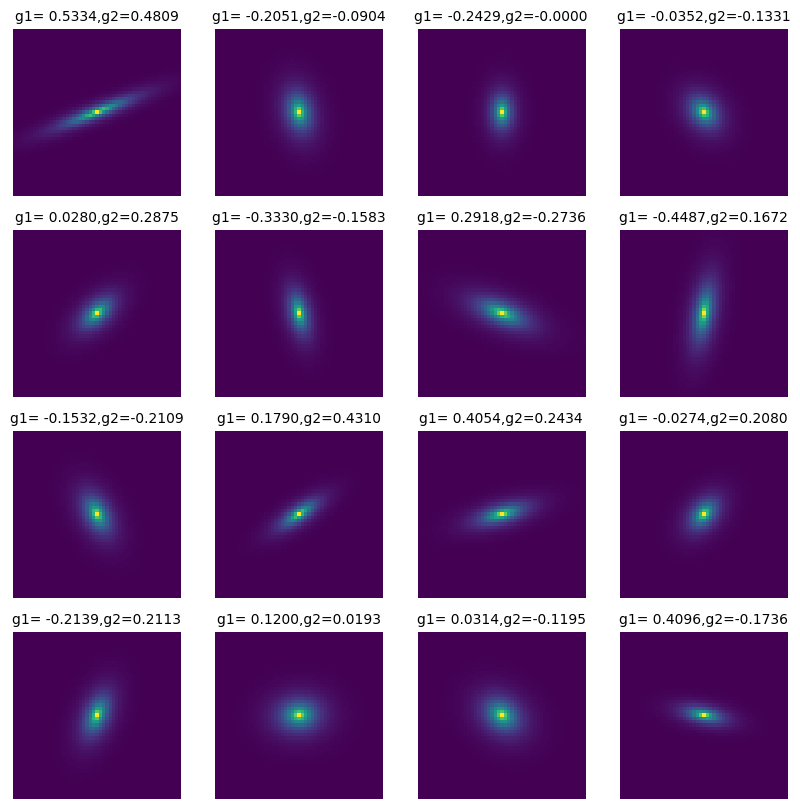

In [4]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images = onebatch['gal_model'] 
labels = onebatch['label'] 
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin='lower')
  title(f"g1= {labels[i][0]:.4f},g2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

In [5]:
sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([[0.,0.05]],len(onebatch['gal_model']),axis=0))

noise_level = 1e-3
noise = np.random.normal(scale=noise_level,size=[1000,51,51])
sheared += noise

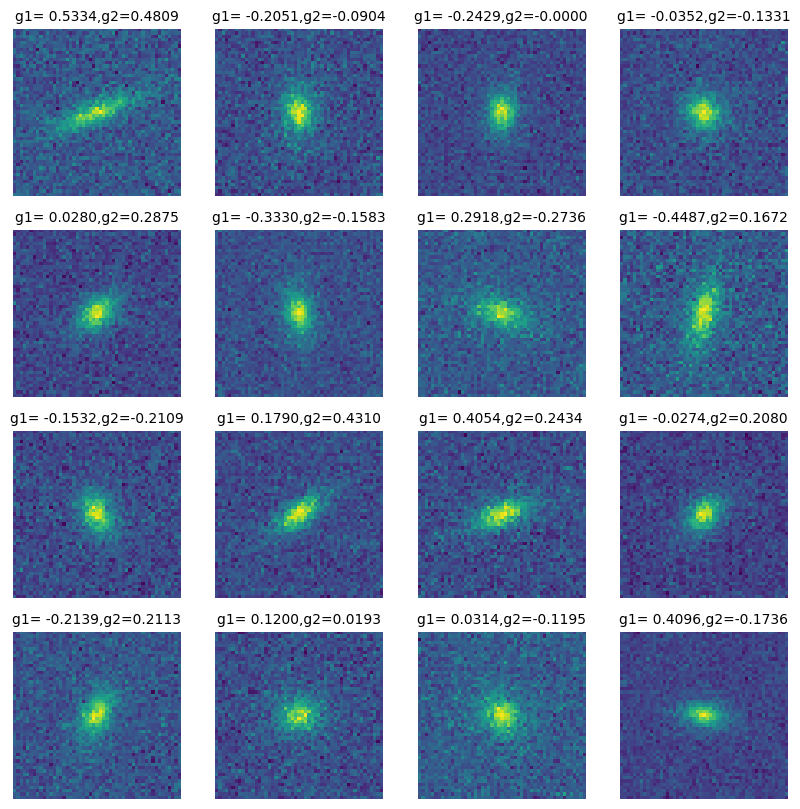

In [6]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(sheared[i],origin= 'lower')
  #imshow(gal_images[i],origin='lower')
  title(f"g1= {labels[i][0]:.4f},g2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

In [7]:
im = sheared[0]
psf_im = onebatch['psf_image'][0] 

In [8]:
scale= .2
stamp_size = 51

jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

In [9]:
wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
psf_wt = tf.reduce_mean(1.0/(noise/100)**2,axis=0)

psf_obs = ngmix.Observation(
  psf_im,
  weight=psf_wt,
  jacobian=psf_jacobian,
)
obs = ngmix.Observation(
  im,
  jacobian=jacobian,
  weight=wt,
  psf=psf_obs,
)

In [10]:
rng = np.random.RandomState(31415)

# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent

types = ['noshear', '1p', '1m','2p','2m']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=types,
  fixnoise=True,
)

In [11]:
resdict, obsdict = boot.go(obs)

In [12]:
def get_metacal_response_ngmix(resdict):
  step=0.01
  types = ['noshear', '1p', '1m','2p','2m']
  e1, e2 = resdict['noshear']['e1'], resdict['noshear']['e2']
 
  g0s = np.array([resdict['noshear']['e1'], resdict['noshear']['e2']])
  g1p = np.array([resdict['1p']['e1'], resdict['1p']['e2']])
  g1m = np.array([resdict['1m']['e1'], resdict['1m']['e2']])
  g2p = np.array([resdict['2p']['e1'], resdict['2p']['e2']])
  g2m = np.array([resdict['2m']['e1'], resdict['2m']['e2']])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)  
   
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])
    
  return ellip_dict, R  

## Shakedown Test!

In [13]:
true = labels[0]
#ngmix calibration
ellips, R_ngmix = get_metacal_response_ngmix(resdict)
calibrated_ngmix = linalg.inv(R_ngmix) @ ellips['noshear']
#AutoMetaCal run
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)
R_auto = amc.get_metacal_response(im[tf.newaxis], psf_im[tf.newaxis],psf_im[tf.newaxis],method)
e_amc=method(im[tf.newaxis])
calibrated_amc = linalg.inv(R_auto[1][0].numpy()) @ e_amc[0].numpy()

In [14]:
print("True:")
print(f"e1={true[0]:.6f}, e2={true[1]:.6f}.")

print("\nngmix:")
print(f"e1={calibrated_ngmix[0]:.6f}, e2={calibrated_ngmix[1]:.6f}.")

print("\nAutoMetaCal")
print(f"e1={calibrated_amc[0]:.6f}, e2={calibrated_amc[1]:.6f}.")

True:
e1=0.533387, e2=0.480920.

ngmix:
e1=0.900972, e2=0.822700.

AutoMetaCal
e1=0.891699, e2=0.816644.


## One Batch Test

In [15]:
batch_size=1000
data= tfds.load('GalGen/small_stamp_1k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
real_shear = [0.01,0.0]
import galsim

psf_fwhm = 0.7
reconv_psf = galsim.Moffat(beta=5.0, 
                    fwhm=psf_fwhm*1.4)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)


reconv_psf_image = obs.psf.image.reshape(1,51,51).astype('float32') 
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)

In [17]:
batchit = data.as_numpy_iterator()

In [18]:
@tf.function
def response(gal_images,psf_images):
  return amc.get_metacal_response(gal_images, psf_images,psf_images,method)

In [19]:
e_amc = []
R_auto = []

onebatch = batchit.next()

sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=noise_level,size=[len(sheared),51,51])
sheared += noise

gal_images = sheared
psf_images = onebatch['psf_image']
e_amc_batch, R_auto_batch = response(gal_images, psf_images)
e_amc.append(e_amc_batch)
R_auto.append(R_auto_batch)
  
e_amc=tf.concat(e_amc,axis=0)
R_auto=tf.concat(R_auto,axis=0)

In [20]:
uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0)

In [21]:
%%timeit
e_amc_batch, R_auto_batch = response(gal_images, psf_images)

4.91 s ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Perform the same test with ngmix:

In [22]:
rng = np.random.RandomState(31415)

# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent

types = ['noshear', '1p', '1m','2p','2m']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=types,
  fixnoise=True,
)

In [23]:
sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=noise_level,size=[len(sheared),51,51])
sheared += noise

gal_images = sheared
psf_images = onebatch['psf_image']

In [24]:
def response_ngmix(im_psf):
  im, psf = im_psf
  
  psf_obs = ngmix.Observation(
    psf_im,
    weight=psf_wt,
    jacobian=psf_jacobian,
  )
  obs = ngmix.Observation(
    im,
    jacobian=jacobian,
    weight=wt,
    psf=psf_obs,
  )
  
  #get moment ellipticities
  resdict, obsdict = boot.go(obs)
  e_ngmix, R_ngmix = get_metacal_response_ngmix(resdict)
  
  return e_ngmix['noshear'], R_ngmix
  


In [25]:
%%timeit
response_ngmix((gal_images[0],psf_images[0]))

92.1 ms ± 737 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


To be fair, let's use ngmix in parallel. 

In [26]:
from multiprocessing import Pool, freeze_support, cpu_count
pool = Pool(cpu_count()) 

In [27]:
gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
psf_imlist = [psf_images[i] for i in range(len(gal_images))]
ims_psfs = zip(gal_imlist,psf_imlist)

In [28]:
t = time.time()
results = pool.map(response_ngmix, ims_psfs)
print(f"Finished in: {time.time()-t} s.")

Finished in: 5.066063642501831 s.


In [29]:
pool.close()

In [30]:
e_ngmix_list = [result[0] for result in results]
R_ngmix_list = [result[1] for result in results]

In [31]:
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)

In [32]:
print("True:")
print(f"e1={real_shear[0]:.6f}, e2={real_shear[1]:.6f}.")

print("\nUncalibrated shear estimation over 1k")
print(f"e1={uncalibrated_shear_amc[0]:.6f}, e2={uncalibrated_shear_amc[1]:.6f}.")

print("\nAutoMetaCal shear estimation over 1k")
print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")

print("\nngmix shear estimation over 1k")
print(f"e1={calibrated_shear_ngmix[0]:.6f}, e2={calibrated_shear_ngmix[1]:.6f}.")

True:
e1=0.010000, e2=0.000000.

Uncalibrated shear estimation over 1k
e1=0.006744, e2=-0.010865.

AutoMetaCal shear estimation over 1k
e1=0.015133, e2=-0.024547.

ngmix shear estimation over 1k
e1=0.014172, e2=-0.023857.


In [33]:
m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] -1 

print("Autometacal:")
print(f"m_1 = {m1_amc: .6f}")

m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
print("\nngmix:")
print(f"m_1 = {m1_ngmix: .6f}")

Autometacal:
m_1 =  0.513300

ngmix:
m_1 =  0.417166


## All Batches Test

In [34]:
batch_size=1000
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [35]:
batchit = data.as_numpy_iterator()

In [36]:
e_amc = []
R_auto = []


for _ in tqdm.tqdm(range(100)):
  onebatch = batchit.next()

  sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                            tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

  noise = np.random.normal(scale=noise_level,size=[len(sheared),51,51])
  sheared += noise

  gal_images = sheared
  psf_images = onebatch['psf_image']

  e_amc_batch, R_auto_batch = response(gal_images, psf_images)
  
  e_amc.append(e_amc_batch)
  R_auto.append(R_auto_batch)
  
e_amc=tf.concat(e_amc,axis=0)
R_auto=tf.concat(R_auto,axis=0)

100%|██████████| 100/100 [12:18<00:00,  7.39s/it]


In [37]:
uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0)

In [38]:
print("True:")
print(f"e1={real_shear[0]:.6f}, e2={real_shear[1]:.6f}.")

print("\nUncalibrated shear estimation over 1k")
print(f"e1={uncalibrated_shear_amc[0]:.6f}, e2={uncalibrated_shear_amc[1]:.6f}.")

print("\nAutoMetaCal shear estimation over 1k")
print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")

m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] -1 

print("\nAutometacal:")
print(f"m_1 = {m1_amc: .6f}")

True:
e1=0.010000, e2=0.000000.

Uncalibrated shear estimation over 1k
e1=0.004617, e2=0.000260.

AutoMetaCal shear estimation over 1k
e1=0.010463, e2=0.000591.

Autometacal:
m_1 =  0.046300


Do the same with ngmix:

In [40]:
batchit = data.as_numpy_iterator()

In [41]:
e_ngmix_list = []
R_ngmix_list = []
for batchno in tqdm.tqdm(range(100)):
  onebatch = batchit.next()

  sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                            tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

  noise = np.random.normal(scale=noise_level,size=[len(sheared),51,51])
  sheared += noise

  gal_images = sheared
  psf_images = onebatch['psf_image']
  gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
  psf_imlist = [psf_images[i] for i in range(len(gal_images))]
  ims_psfs = zip(gal_imlist,psf_imlist)
  
  pool = Pool(cpu_count()//2)
  results = pool.map(response_ngmix, ims_psfs)
  pool.close()
  
  e_ngmix_list += [result[0] for result in results]
  R_ngmix_list += [result[1] for result in results]


  

100%|██████████| 100/100 [24:02<00:00, 14.43s/it]


In [42]:
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)  

In [43]:
print("True:")
print(f"e1={real_shear[0]:.6f}, e2={real_shear[1]:.6f}.")

print("\nUncalibrated shear estimation over 1k")
print(f"e1={uncalibrated_shear_amc[0]:.6f}, e2={uncalibrated_shear_amc[1]:.6f}.")

print("\nAutoMetaCal shear estimation over 1k")
print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")

print("\nngmix shear estimation over 1k")
print(f"e1={calibrated_shear_ngmix[0]:.6f}, e2={calibrated_shear_ngmix[1]:.6f}.")

True:
e1=0.010000, e2=0.000000.

Uncalibrated shear estimation over 1k
e1=0.004617, e2=0.000260.

AutoMetaCal shear estimation over 1k
e1=0.010463, e2=0.000591.

ngmix shear estimation over 1k
e1=0.010598, e2=0.000420.


In [44]:
m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] -1 

print("Autometacal:")
print(f"m_1 = {m1_amc: .6f}")

m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
print("\nngmix:")
print(f"m_1 = {m1_ngmix: .6f}")

Autometacal:
m_1 =  0.046300

ngmix:
m_1 =  0.059845
